In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow 
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras import layers, callbacks
from torch import nn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from xgboost import XGBRFRegressor
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2021/train.csv
/kaggle/input/tabular-playground-series-jul-2021/test.csv


In [2]:
from datetime import datetime
data_1 = pd.read_csv('../input/tabular-playground-series-jul-2021/train.csv')
data_2 = pd.read_csv('../input/tabular-playground-series-jul-2021/test.csv')

In [3]:
target = data_1.iloc[:,data_1.columns.str.contains('target')]
y = target.copy()
x = data_1.drop(y.columns , axis = 1)

x.head()


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2


In [4]:
data_1['date_time'] = pd.to_datetime(data_1.date_time, format = "%Y-%m-%d %H:%M:%S")
data_1['season'] = data_1.date_time.apply(lambda x: x.month%12/3 + 1).astype(int)
data_1.season.value_counts()

3    2208
4    2184
2    1974
1     745
Name: season, dtype: int64

In [5]:
data_2['date_time'] = pd.to_datetime(data_2.date_time, format = "%Y-%m-%d %H:%M:%S")
data_2['season'] = data_2.date_time.apply(lambda x: x.month%12/3 + 1).astype(int)
data_2['day'] = data_2.date_time.apply(lambda x:x.weekday())
data_2.season.value_counts()

1    1416
2     831
Name: season, dtype: int64

In [6]:
data_1['day'] = data_1.date_time.apply(lambda x:x.weekday())
data_1.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,season,day
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7,2,2
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9,2,2
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1,2,2
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2,2,2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8,2,2


In [7]:
x = x.drop('date_time', axis = 1)
x['season'] = data_1.season
x['day'] = data_1.day
x['Nc'] = (data_1.absolute_humidity * 100 / data_1.relative_humidity)
data_1['nc'] = x.Nc
x.head()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,season,day,Nc
0,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2,2,1.647391
1,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2,2,1.601545
2,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2,2,1.334875
3,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2,2,1.260737
4,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,2,2,1.336949


In [8]:
data_2 = data_2.drop('date_time', axis = 1)
data_2['Nc'] = (data_2.absolute_humidity * 100 / data_2.relative_humidity)
data_2.head()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,season,day,Nc
0,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1,1,5,1.059322
1,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0,1,5,0.882785
2,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8,1,5,0.910485
3,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0,1,5,0.897323
4,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3,1,5,0.808696


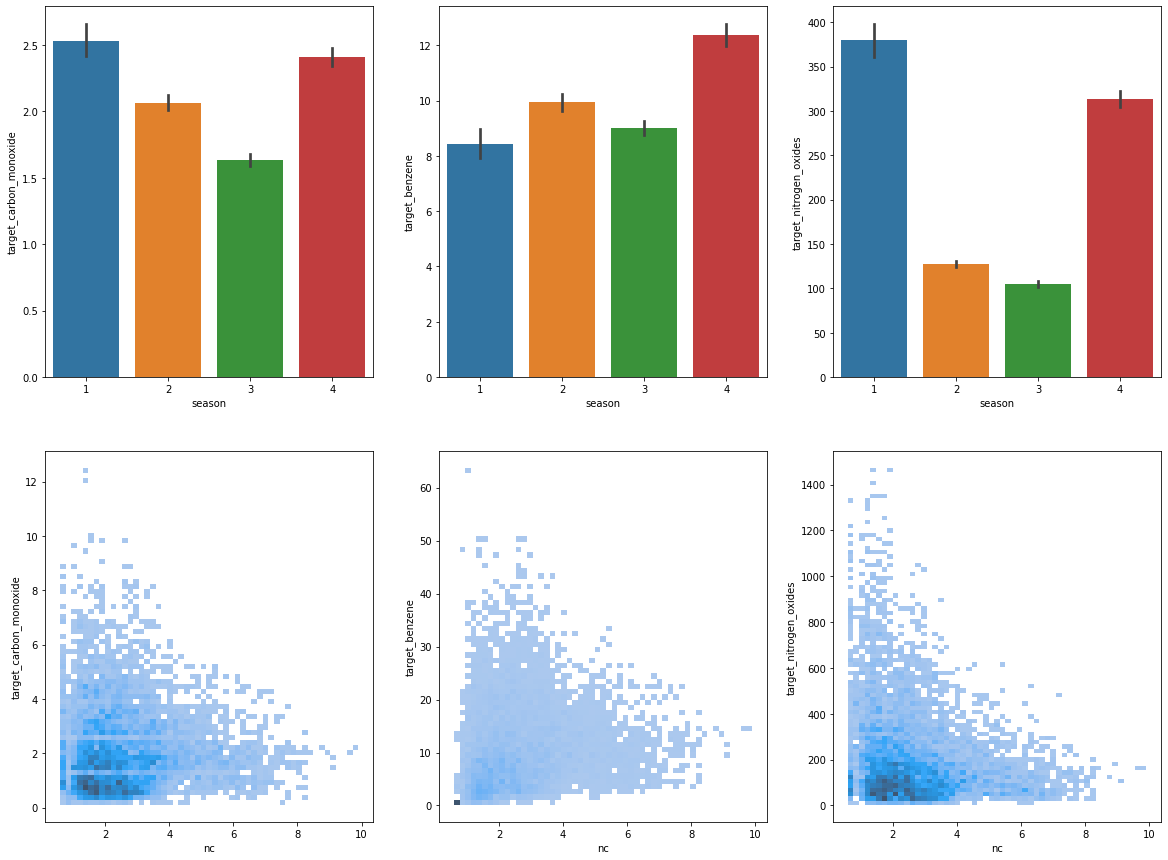

In [9]:
fig, ax = plt.subplots(2, 3, figsize = (20, 15))
i = 0
for j in target.columns:
    sns.barplot(x = data_1.season, y = data_1[f"{j}"], ax =ax[0][i])
    sns.histplot(x = data_1.nc, y = data_1[f"{j}"], ax =ax[1][i])
    #ax[i].set_title(f"{j}")
    
    i += 1

array([[<AxesSubplot:title={'center':'deg_C'}>,
        <AxesSubplot:title={'center':'relative_humidity'}>,
        <AxesSubplot:title={'center':'absolute_humidity'}>],
       [<AxesSubplot:title={'center':'sensor_1'}>,
        <AxesSubplot:title={'center':'sensor_2'}>,
        <AxesSubplot:title={'center':'sensor_3'}>],
       [<AxesSubplot:title={'center':'sensor_4'}>,
        <AxesSubplot:title={'center':'sensor_5'}>,
        <AxesSubplot:title={'center':'season'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'Nc'}>, <AxesSubplot:>]],
      dtype=object)

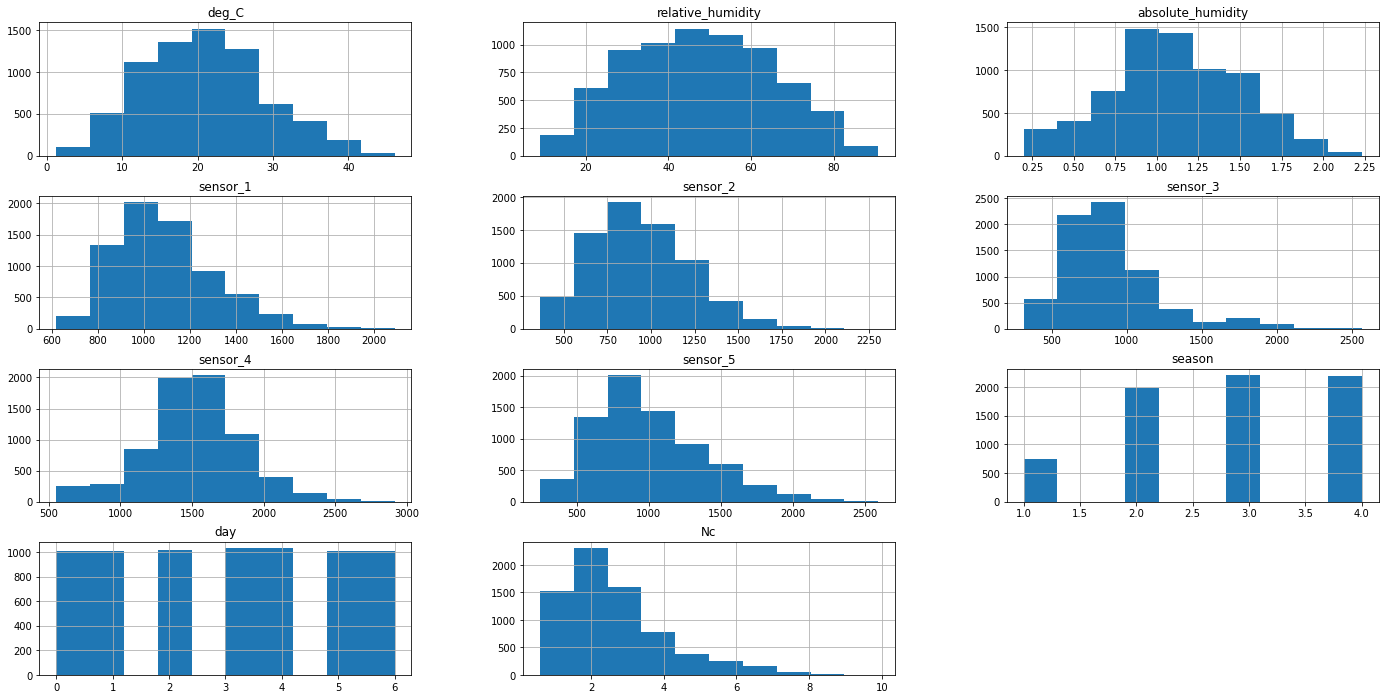

In [10]:
x.hist(figsize = (24,12))

<AxesSubplot:>

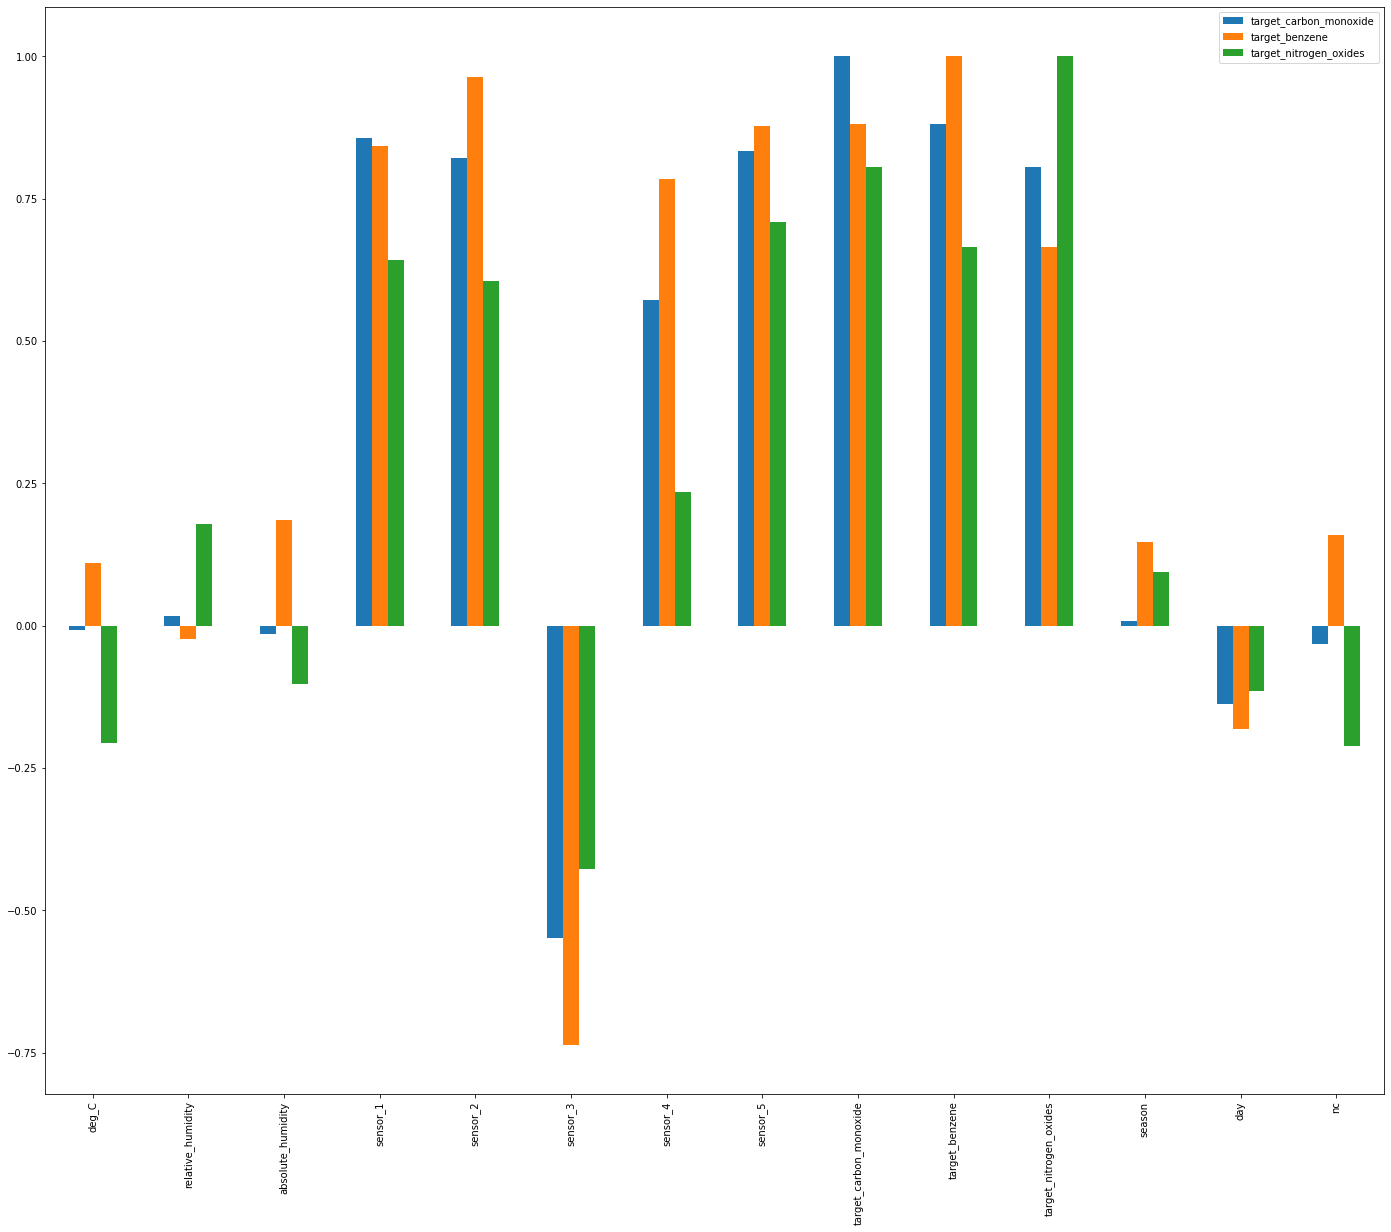

In [11]:
data_1.corr()[target.columns].plot.bar(figsize = (24,20))

<AxesSubplot:>

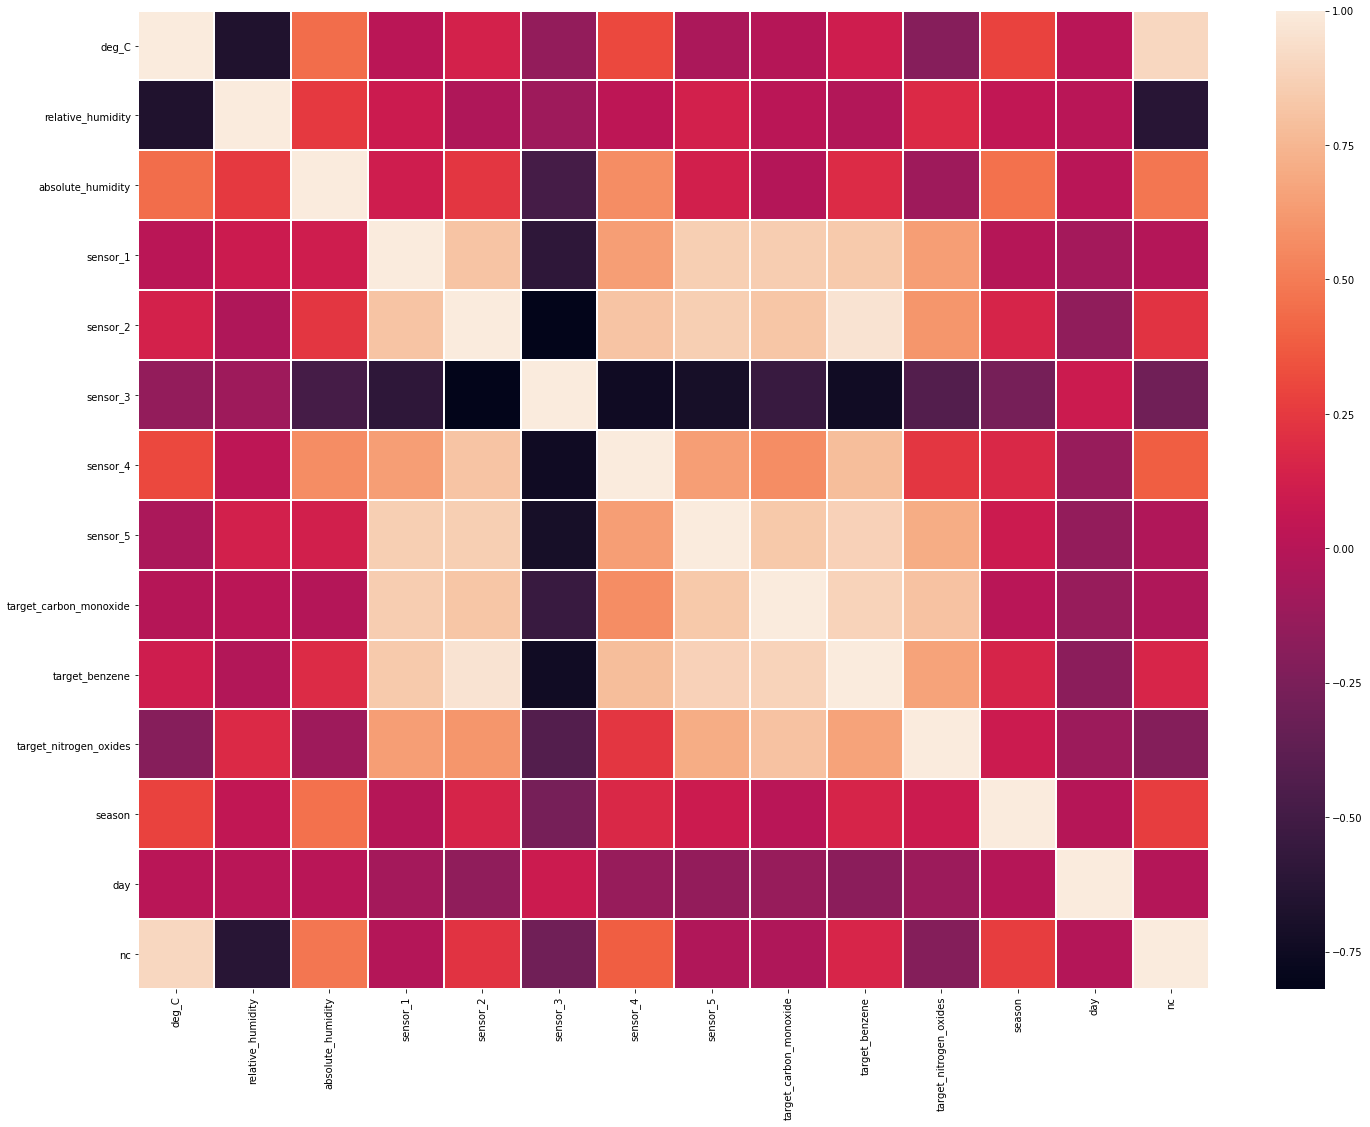

In [12]:
fig = plt.figure(figsize = (24,18))
sns.heatmap(data_1.corr(), linewidth = 0.09)

In [13]:
train_x, val_x, train_y, val_y = train_test_split(x, target, test_size = 0.3, random_state = 1)

In [14]:
rc = RobustScaler()
t_x = pd.DataFrame(rc.fit_transform(train_x))
v_x = pd.DataFrame(rc.fit_transform(val_x))
test = pd.DataFrame(rc.fit_transform(data_2))

In [15]:
model_1 = RandomForestRegressor(n_estimators = 500)
model_1.fit(train_x, train_y)
pred = model_1.predict(val_x)
error = np.sqrt(mean_squared_log_error(val_y,pred))
print(error)


0.17218436561321443


In [16]:
import xgboost
from sklearn.multioutput import MultiOutputRegressor
model_ = xgboost.XGBRFRegressor(n_estimators = 500)
model_2 = MultiOutputRegressor(model_)
model_2.fit(train_x, train_y )
pred_2 = model_2.predict(val_x)
error_2 = np.sqrt(mean_squared_log_error(pred_2, val_y))
print(error_2)

0.21165070930081212


In [17]:
model3 = keras.Sequential([layers.BatchNormalization(),
    layers.InputLayer(input_shape = [train_x.shape[1]]),
    layers.Dense(128, kernel_initializer = 'normal', activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dense(128, kernel_initializer = 'normal', activation = 'relu'),
    layers.Dense(3, activation = 'linear')
])

In [18]:
model3.compile( optimizer = 'adam',
             loss = 'msle')
call = callbacks.EarlyStopping( patience = 10, 
                              min_delta = 0.001,
                              restore_best_weights = True)

In [19]:
h = model3.fit(train_x, train_y, validation_split = 0.2, 
               callbacks = [call], epochs = 1000, batch_size = 128, verbose = 0)

0.1954813037015437 0.18124429471803494


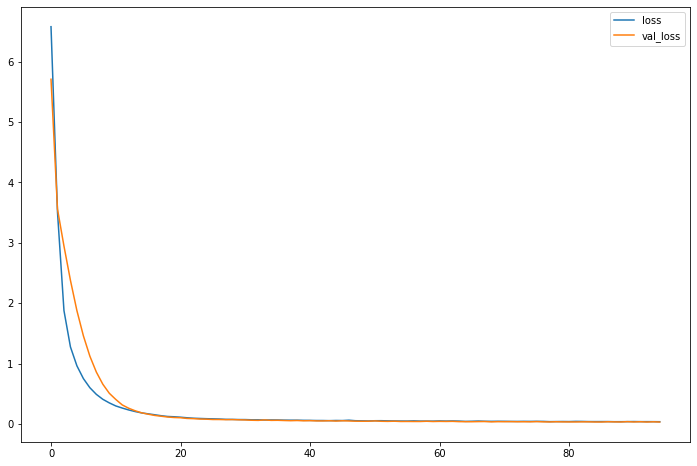

In [20]:
out = pd.DataFrame(h.history)
out.plot(figsize = (12,8))
print(np.sqrt(out.loss.min()), np.sqrt(out.val_loss.min()))

In [21]:
ex = model3.predict(val_x)
result = np.sqrt(mean_squared_log_error(abs(ex), abs(val_y)))
print(result)

0.2176238798068745


In [22]:
ans =pd.DataFrame(model3.predict(data_2))

In [23]:
output = pd.read_csv("../input/tabular-playground-series-jul-2021/sample_submission.csv")

In [24]:
ans.columns = y.columns

In [25]:
for i in ans.columns:
    output[f"{i}"] = ans[f"{i}"]
output.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.434989,5.815034,281.953613
1,2011-01-01 01:00:00,2.595023,8.650958,420.128845
2,2011-01-01 02:00:00,1.816573,8.412879,376.253296
3,2011-01-01 03:00:00,2.255662,9.392371,372.443481
4,2011-01-01 04:00:00,1.871697,7.271913,284.370026


In [26]:
output.to_csv('submission_5', index = False)